In this project we are performing unsupervised evaluation of LLM translation on instances of Adjective + Noun Pairs.
The source of Model Outputs is gpt-4o under a set prompt. We'll use several NLP models for corpora access and processing; as well as Wiktionary dumps for definitions and direct translations. Detailed project info can be found in README

Starting with processing raw JSON dictionaries for desired target and source languages. Those are manually downloaded from https://kaikki.org/dictionary/rawdata.html

In [9]:
from pathlib import Path
project_root = Path().resolve().parents[1]   # adjust 1 or 2 levels depending on layout

data = project_root/'data'

Set of parameters for the algorithm - Source_lang, source_lang_code, Target_lang, target_lang_code, part of speech (plural)

In [10]:
%run {data}/processing/filter.py 'English' 'en' 'Russian' 'ru' 'adjectives'
%run {data}/processing/filter.py 'Russian' 'ru' 'English' 'en' 'adjectives'
%run {data}/processing/filter.py 'English' 'en' 'Russian' 'ru' 'nouns'
%run {data}/processing/filter.py 'Russian' 'ru' 'English' 'en' 'nouns'
#...

In [11]:
import pandas as pd

for chunk in pd.read_csv(project_root/'data'/'processed'/'en_nouns.csv', chunksize=10):
    print(chunk)
    break

         word                       ru  \
0  dictionary  ["словарь", "лексикон"]   
1  dictionary  ["словарь", "лексикон"]   
2  dictionary  ["словарь", "лексикон"]   
3  dictionary  ["словарь", "лексикон"]   
4  dictionary  ["словарь", "лексикон"]   
5  dictionary  ["словарь", "лексикон"]   
6        free                       []   
7        free                       []   
8        free                       []   
9        free                       []   

                                               gloss gloss_ru  \
0  A reference work listing words or names from o...       []   
1  A reference work on a particular subject or ac...       []   
2  A person or thing regarded as a repository or ...       []   
3  The collection of words used or understood by ...       []   
4  A synchronic dictionary of a standardised lang...       []   
5  An associative array, a data structure where e...       []   
6                          Abbreviation of free kick       []   
7                

Now let's import the GPT wrapper and request a set for evaluation. The pairs will then be converted into a custom class of AdjectiveNounPair (subclass of Word). All pairs will then be treated as instances of this class.

In [12]:
from models.Gemini import *
from objects.AdjectiveNounPair import *

input_source, input_target = gemini.request(20, 'Russian')

input_source = [i.strip().lower() for i in input_source.split(',')]
input_target = [i.strip().lower() for i in input_target.split(',')]

source_to_target = dict()
for i in range(len(input_source)):
    print(input_source[i], input_target[i])
    if (input_source[i] + input_target[i]).count(' ') != 2:
        continue
    source = AdjectiveNounPair(input_source[i], 'en')
    target = AdjectiveNounPair(input_target[i], 'ru')
    source_to_target[source] = target


blind spot слепое пятно
dark horse тёмная лошадка
hard nut крепкий орешек
blue moon голубая луна
golden opportunity золотая возможность
rough diamond неотёсанный алмаз
white lie белая ложь
square peg квадратный кол
wild goose дикий гусь
sharp tongue острый язык
red herring красный селёдка
dead end тупиковая конец
heavy heart тяжелый сердце
thin skin тонкий кожа
light touch легкий прикосновение
black sheep черный овца
old hand старый рука
big fish большой рыба
empty nest опустевший гнездо
hot potato горячая картофель


Now each of the pairs will be processed with functions from eval_factors.py to get output scores.

In [13]:
from src.factors.eval_factors import *

evals = pd.DataFrame(columns=[
    'source',
    'target',
    'cosine_similarity',
    'natural_fluency',
    'dictionary_match',
    'commonness_match'])

Will process all evals for all input pairs parsing results into a DataFrame

In [14]:
for source in source_to_target:

    cosine_score = cosine_similarity(source, source_to_target[source])
    #cosine similarity using 'paraphrase-multilingual-MiniLM-L12-v2' for pretty accurate vector similarity score
    natflu_score = natural_fluency(source_to_target[source])
    #a set of determinants as 'case' match, correct order of two words, etc. combined into a whole score
    dictionary_score = dictionary_translation_match(source, source_to_target[source])
    #dictionary will often have translations of source words to target language, we assess how they match
    commonness_score = commonness_match(source, source_to_target[source])
    #psuedo perplexity check to determine how well commonness of source words relates to
    #commonness of target words
    instance = [
    source.original,
    source_to_target[source].original,
    cosine_score,
    natflu_score,
    dictionary_score,
    commonness_score]

    evals.loc[len(evals)] = instance

In [15]:
print(evals)

                source                target  cosine_similarity  \
0           blind spot          слепое пятно              0.834   
1           dark horse        темная лошадка              0.986   
2             hard nut        крепкий орешек              0.580   
3            blue moon          голубая луна              0.974   
4   golden opportunity   золотая возможность              0.925   
5        rough diamond     неотесанный алмаз              0.863   
6            white lie            белая ложь              0.943   
7           square peg        квадратный кол              0.783   
8           wild goose            дикий гусь              0.662   
9         sharp tongue           острый язык              0.845   
10         red herring       красный селедка              0.577   
11            dead end       тупиковая конец              0.778   
12         heavy heart        тяжелый сердце              0.946   
13           thin skin           тонкий кожа              0.89

    cosine_similarity  natural_fluency  dictionary_match  commonness_match
0               0.834            0.917               1.0             0.834
1               0.986            0.917               0.9             0.540
2               0.580            0.917               0.9             0.280
3               0.974            0.917               0.5             0.690
4               0.925            0.917               0.5             0.797
5               0.863            0.917               0.5             0.000
6               0.943            0.917               1.0             0.000
7               0.783            0.917               0.4             0.000
8               0.662            0.917               1.0             0.917
9               0.845            0.917               1.0             0.541
10              0.577            0.583               0.9             0.801
11              0.778            0.583               0.4             0.498
12              0.946    

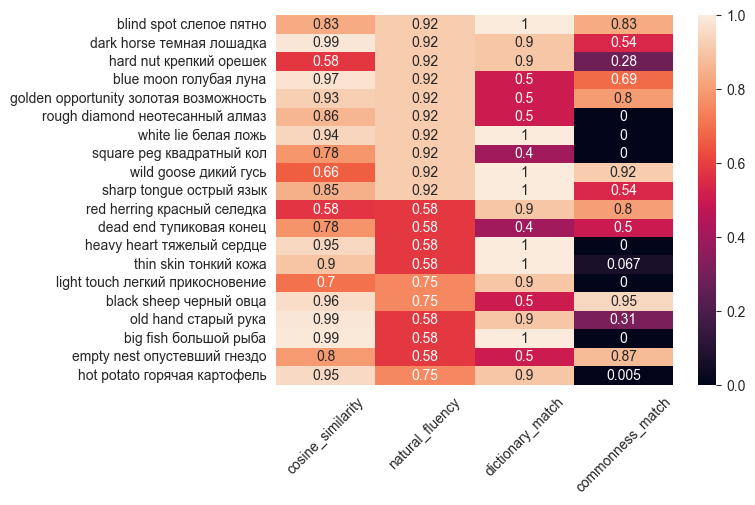

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print(evals.iloc[:,2:])
ax = sns.heatmap(evals.iloc[:,2:], annot=True)

print([key.original + ' ' + source_to_target[key].original for key in source_to_target.keys()])
ax.set_yticklabels([key.original + ' ' + source_to_target[key].original for key in source_to_target.keys()], rotation=0)
ax.set_xticklabels(evals.columns[2:], rotation=45)

plt.show()